In [1]:
from sklearn.cluster import KMeans
import sys
# sys.path.insert(1, '../permus_util')
# sys.path.insert(0, '/Users/ekhi/Desktop/gits/top-k-mallows')

import mallows_kendall as mk
import permutil as pu
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import math
from scipy.stats import rankdata
from scipy.stats import norm

# Data description

This dataset has been generated a collection of students of 'Ecomomics and Enterprise' in Tecnun. Each student provides a ranking of 4 words in order of similarity to the word 'Amortización' (amortization). The words are: 'Depreciación' (depreciation), 'Gasto' (expense), 'Vida útil' (lifetime), 'Pago' (payment). There exists a real ground-true ranking, which is denoted along the experiment as $s0$, $s0=$['Depreciación', 'Gasto', 'Vida útil', 'Pago'] = [0,1,2,3].

There are two different samples in this dataset:

- sample 1: the experiment is carried out **before** the class, 
- sample 2: the experiment is carried out **after** the class.


The questions that we try to solve are:

- Do the students *learn* in the class? Do the answers after the class closer to the ground-true ranking?
- In general, we have access to the sample but do not have access to the ground-true answer. Can we separete the expert students from the non-expert students with statistics from the sample (with out knowing $s0$?

## References

This work is a real-word experimental evaluation of WP ??? in the project SENDAI (Eklartek program). The theoretical background can be found in \[2].


- \[1]  A Learning Theory of Ranking Aggregation
Anna Korba, Stéphan Clemencon, Eric Sibony. Proceedings of the 20th International Conference on Artificial Intelligence and Statistics, PMLR 54:1001-1010, 2017.
- \[2] Concentric mixtures of Mallows models for top-k rankings: sampling and identifiability. Fabien Collas, Ekhine Irurozki. https://arxiv.org/abs/2010.14260 

In [2]:
dfstu = pd.read_csv('./students.csv')
perms = dfstu[['i0', 'i1', 'i2', 'i3']].values
n,true_ranking = 4,[0,1,2,3]
d_center,depths, res = [], [], []
P = pu.sample_to_marg_rel(perms)
for perm in perms:
    d_center.append( mk.distance(true_ranking, perm) )
    depths.append( n*(n-1)/2 -  pu.dist_to_sample(perm,P) )
dfstu["Distance to center"] = d_center
dfstu["Depth"] = depths

dfstu.head()

,i0,i1,i2,i3,When,Distance to center,Depth
0,3,2,0,1,Before class,5,2.864943
1,2,3,0,1,Before class,4,3.181034
2,0,3,1,2,Before class,2,3.663793
3,3,1,0,2,Before class,4,3.250000
4,3,0,2,1,Before class,4,2.336207


In [3]:
# Transform the frames
print(dfstu.shape)
d1 = dfstu[dfstu['When'] == "Before class"][["i0", "i1", "i2", "i3"]].to_numpy()
print(d1.shape)
d2 = dfstu[dfstu['When'] == "After class"][["i0", "i1", "i2", "i3"]].to_numpy()
print(d2.shape)

(348, 7)
(169, 4)
(179, 4)


# Improvement after class

The fist question is to analyze wheter the students' answers improved by taking the class. The most direct approach is to measure 

- the distance between the average ranking of the student **before** the class and the ground-true ranking ($s0$) and
- the distance between the average ranking of the student **after** the class and the ground-true ranking ($s0$).

The average ranking before the class was further than the average distance after the class. Therefore, we can conclude that the students did learn in the class. 


In [4]:
avg_ranking_before = np.argsort(np.argsort(d1.sum(axis=0)))
avg_ranking_after = np.argsort(np.argsort(d2.sum(axis=0)))
print("The distance of the average ranking before the class is", mk.distance(true_ranking,avg_ranking_before))
print("The distance of the average ranking after the class is", mk.distance(true_ranking,avg_ranking_after))
print("Did the students learn?", mk.distance(true_ranking,avg_ranking_before) > mk.distance(true_ranking,avg_ranking_after))


The distance of the average ranking before the class is 2
The distance of the average ranking after the class is 1
Did the students learn? True


# Formal testing procedure

In the above paragraph, the improvement of the students performance was measured based on distance. While this already gives an idea about their amelioration, no guarantee is given here that the improvement is significant.

To check the guarantee that the performance of the studnets is indeed statistically significantly different after the class, we construct a testing procedure outlined above.

In [5]:
print(d1.shape)
print(type(d1))
print(d2.shape)

(169, 4)
<class 'numpy.ndarray'>
(179, 4)


## Compile depth library

Compile C++ codes if necessary

In [6]:
# Compilation
# import os
# os.system('clang++ -mmacosx-version-min=10.13 -std=gnu++11 -fPIC  -Wall -g -O2  -c rankDepth.cpp -o rankDepth.o')
# os.system('clang++ -mmacosx-version-min=10.13 -std=gnu++11 -dynamiclib -Wl,-headerpad_max_install_names -undefined dynamic_lookup -single_module -multiply_defined suppress -o rankDepth.so rankDepth.o')
# Restart the kernel after this line

Import (and test) the dynamic library

In [7]:
# Import and Test 1
from ctypes import *
cdll.LoadLibrary('rankDepth.so')
libc = CDLL('rankDepth.so')
libc.testFunc()

43

In [8]:
# Test 2
val = np.array([5.1])
obj = np.array([0.1, 1.1, 2.1, 3.1, 4.1, 5.1, 6.1, 7.1, 8.1, 9.1])
n = 10
outp = np.array([1.1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
res2 = libc.testFuncCmp(c_void_p(val.ctypes.data),
                       c_void_p(obj.ctypes.data),
                       c_int(n),
                       c_void_p(outp.ctypes.data))
print(res2)
print(outp)

0
[  1.1   0.    0.    0.    0.    0.    0.    0.    0.  142. ]


Depth-calculating Python function

In [9]:
def qrdepth(objects, data):
    '''
    The function to calculate the qr-depths
    '''
    depths = np.zeros(objects.shape[0])
    for i in range(objects.shape[0]):
        for j in range(data.shape[0]):
            depths[i] += (mk.max_dist(objects.shape[1]) - mk.distance(objects[i,:], data[j,:])) / mk.max_dist(objects.shape[1])
        depths[i] /= data.shape[0]
    return depths

## Exploratory DD-plot

Plotting DD-plot


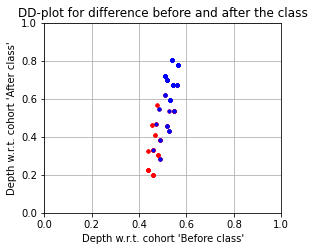

In [10]:
print("Plotting DD-plot")
depths1 = np.transpose(np.array([qrdepth(d1, d1), qrdepth(d1, d2)]))
depths2 = np.transpose(np.array([qrdepth(d2, d1), qrdepth(d2, d2)]))
plt.close("all")
plt.figure(1, figsize=(4.25, 3.5))
plt.title("DD-plot for difference before and after the class")
plt.plot(depths1[:,0], depths1[:,1], 'r.')
plt.plot(depths2[:,0], depths2[:,1], 'b.')
plt.xlabel("Depth w.r.t. cohort 'Before class'")
plt.ylabel("Depth w.r.t. cohort 'After class'")
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.grid()
plt.savefig("pic-ddplot-tecnun.pdf")

## Case 1

Pick randomly 100 observations from 'd1' as reference, and test using the rest of 'd1' (69) and 79 randomly picked observations from 'd2'.

In [11]:
random.seed(1)
print("Testing: first as reference")
# Prepare the data arrays
tmpD1 = np.array(d1, copy = True)
tmpD2 = np.array(d2, copy = True)
random.shuffle(tmpD1)
random.shuffle(tmpD2)
empDist1 = tmpD1[100:,:]
empDist2 = tmpD2[100:,:]
empDistR = tmpD1[:100,:]
# Calculate the depth statistics
depthsTest1 = qrdepth(empDist1, empDistR)
depthsTest2 = qrdepth(empDist2, empDistR)
depthsTestR = qrdepth(empDistR, empDistR)
pDSmaller1 = np.zeros(depthsTest1.shape[0])
for i in range(depthsTest1.shape[0]):
    pDSmaller1[i] = np.mean(depthsTestR < depthsTest1[i])
pDSmaller2 = np.zeros(depthsTest2.shape[0])
for i in range(depthsTest2.shape[0]):
    pDSmaller2[i] = np.mean(depthsTestR < depthsTest2[i])
# Caculate the test statistics
print("Calculating the p-value")
nX = depthsTest1.shape[0]
nY = depthsTest2.shape[0]
print(nX, nY)
W = np.sum(rankdata(np.concatenate((pDSmaller1, pDSmaller2)))[nX:(nX + nY)])
print(W)
Wmean = nY * (nX + nY + 1) / 2
Wvar = nX * nY * (nX + nY + 1) / 12
pr = norm.cdf(W, Wmean, np.sqrt(Wvar))
pValue1 = min(pr, 1 - pr)
print(pValue1)

Testing: first as reference
Calculating the p-value
69 79
6725.0
0.0006257838147268879


## Case 2

Pick randomly 100 observations from 'd2' as reference, and test using the rest of 'd2' (79) and 69 randomly picked observations from 'd1'.

In [12]:
random.seed(1)
print("Testing: first as reference")
# Prepare the data arrays
tmpD1 = np.array(d1, copy = True)
tmpD2 = np.array(d2, copy = True)
random.shuffle(tmpD1)
random.shuffle(tmpD2)
empDist1 = tmpD1[100:,:]
empDist2 = tmpD2[100:,:]
empDistR = tmpD2[:100,:]
# Calculate the depth statistics
depthsTest1 = qrdepth(empDist1, empDistR)
depthsTest2 = qrdepth(empDist2, empDistR)
depthsTestR = qrdepth(empDistR, empDistR)
pDSmaller1 = np.zeros(depthsTest1.shape[0])
for i in range(depthsTest1.shape[0]):
    pDSmaller1[i] = np.mean(depthsTestR < depthsTest1[i])
pDSmaller2 = np.zeros(depthsTest2.shape[0])
for i in range(depthsTest2.shape[0]):
    pDSmaller2[i] = np.mean(depthsTestR < depthsTest2[i])
# Caculate the test statistics
print("Calculating the p-value")
nX = depthsTest1.shape[0]
nY = depthsTest2.shape[0]
print(nX, nY)
W = np.sum(rankdata(np.concatenate((pDSmaller1, pDSmaller2)))[:nX])
print(W)
Wmean = nX * (nX + nY + 1) / 2
Wvar = nX * nY * (nX + nY + 1) / 12
pr = norm.cdf(W, Wmean, np.sqrt(Wvar))
pValue2 = min(pr, 1 - pr)
print(pValue2)

Testing: first as reference
Calculating the p-value
69 79
3701.0
1.572808669502218e-08


## Case 1 - extended

In [13]:
random.seed(1)
pValues = np.ones(1000)
tStats = np.zeros(1000)
print("Testing: using 'before' as reference, over 100 repetitions")
for i in range(len(pValues)):
    print("Starting iteration " + str(i))
    # Prepare the data arrays
    tmpD1 = np.array(d1, copy = True)
    tmpD2 = np.array(d2, copy = True)
    random.shuffle(tmpD1)
    random.shuffle(tmpD2)
    empDist1 = tmpD1[100:,:]
    empDist2 = tmpD2[100:,:]
    empDistR = tmpD1[:100,:]
    # Calculate the depth statistics
    depthsTest1 = qrdepth(empDist1, empDistR)
    depthsTest2 = qrdepth(empDist2, empDistR)
    depthsTestR = qrdepth(empDistR, empDistR)
    pDSmaller1 = np.zeros(depthsTest1.shape[0])
    for j in range(depthsTest1.shape[0]):
        pDSmaller1[j] = np.mean(depthsTestR < depthsTest1[j])
    pDSmaller2 = np.zeros(depthsTest2.shape[0])
    for j in range(depthsTest2.shape[0]):
        pDSmaller2[j] = np.mean(depthsTestR < depthsTest2[j])
    # Caculate the test statistics
    print("Calculating the p-value")
    nX = depthsTest1.shape[0]
    nY = depthsTest2.shape[0]
    print(nX, nY)
    W = np.sum(rankdata(np.concatenate((pDSmaller1, pDSmaller2)))[nX:(nX + nY)])
    print(W)
    Wmean = nY * (nX + nY + 1) / 2
    Wvar = nX * nY * (nX + nY + 1) / 12
    pr = norm.cdf(W, Wmean, np.sqrt(Wvar))
    pValue1 = min(pr, 1 - pr)
    print(pValue1)
    # Store the p-value and the t-statistic
    pValues[i] = pValue1
    tStats[i] = W

Testing: using 'before' as reference, over 100 repetitions
Starting iteration 0
Calculating the p-value
69 79
6725.0
0.0006257838147268879
Starting iteration 1
Calculating the p-value
69 79
6960.0
1.8126336442048085e-05
Starting iteration 2
Calculating the p-value
69 79
6332.0
0.04305803534635999
Starting iteration 3
Calculating the p-value
69 79
6721.0
0.0006602550996634982
Starting iteration 4
Calculating the p-value
69 79
6609.5
0.0026937511132880676
Starting iteration 5
Calculating the p-value
69 79
7080.5
2.18118013550761e-06
Starting iteration 6
Calculating the p-value
69 79
5873.0
0.4808392544273469
Starting iteration 7
Calculating the p-value
69 79
6777.0
0.00030544046223124344
Starting iteration 8
Calculating the p-value
69 79
6166.5
0.14004785609053816
Starting iteration 9
Calculating the p-value
69 79
6880.5
6.550057892040773e-05
Starting iteration 10
Calculating the p-value
69 79
6653.0
0.0015883189867470504
Starting iteration 11
Calculating the p-value
69 79
5966.0
0.37849

Calculating the p-value
69 79
5600.0
0.13623298058507471
Starting iteration 102
Calculating the p-value
69 79
6512.5
0.007975059743437152
Starting iteration 103
Calculating the p-value
69 79
5548.5
0.09759864356162207
Starting iteration 104
Calculating the p-value
69 79
6014.5
0.31000060971136023
Starting iteration 105
Calculating the p-value
69 79
6682.5
0.0010938252920288383
Starting iteration 106
Calculating the p-value
69 79
6359.0
0.03437695193148982
Starting iteration 107
Calculating the p-value
69 79
6721.0
0.0006602550996634982
Starting iteration 108
Calculating the p-value
69 79
6951.0
2.1057834597382197e-05
Starting iteration 109
Calculating the p-value
69 79
6729.5
0.0005889942824641725
Starting iteration 110
Calculating the p-value
69 79
6489.5
0.010125953968748491
Starting iteration 111
Calculating the p-value
69 79
6769.0
0.00034190869493611054
Starting iteration 112
Calculating the p-value
69 79
6039.5
0.27694427438735936
Starting iteration 113
Calculating the p-value
69

Calculating the p-value
69 79
6979.5
1.3048118484682014e-05
Starting iteration 203
Calculating the p-value
69 79
6891.5
5.512498989379555e-05
Starting iteration 204
Calculating the p-value
69 79
7334.0
1.2904220803022781e-08
Starting iteration 205
Calculating the p-value
69 79
7475.0
4.990909907576224e-10
Starting iteration 206
Calculating the p-value
69 79
6193.5
0.1182289725817629
Starting iteration 207
Calculating the p-value
69 79
6571.0
0.004207899171669416
Starting iteration 208
Calculating the p-value
69 79
7166.0
4.283862965470675e-07
Starting iteration 209
Calculating the p-value
69 79
6909.0
4.1751593800154474e-05
Starting iteration 210
Calculating the p-value
69 79
6999.5
9.26190055550169e-06
Starting iteration 211
Calculating the p-value
69 79
6635.5
0.0019705327666469374
Starting iteration 212
Calculating the p-value
69 79
6672.5
0.0012429151129318416
Starting iteration 213
Calculating the p-value
69 79
6482.5
0.010873977686915559
Starting iteration 214
Calculating the p-v

Calculating the p-value
69 79
7101.5
1.4766164340151988e-06
Starting iteration 304
Calculating the p-value
69 79
7065.5
2.871051478225972e-06
Starting iteration 305
Calculating the p-value
69 79
6968.0
1.5849777580512203e-05
Starting iteration 306
Calculating the p-value
69 79
6847.5
0.00010877069587211796
Starting iteration 307
Calculating the p-value
69 79
5899.0
0.4793077191790197
Starting iteration 308
Calculating the p-value
69 79
6957.0
1.905752199993227e-05
Starting iteration 309
Calculating the p-value
69 79
7192.0
2.558025284926657e-07
Starting iteration 310
Calculating the p-value
69 79
6935.5
2.718775627041925e-05
Starting iteration 311
Calculating the p-value
69 79
6317.0
0.04859877428535608
Starting iteration 312
Calculating the p-value
69 79
6806.0
0.0002014273429365998
Starting iteration 313
Calculating the p-value
69 79
6545.5
0.005591946192523678
Starting iteration 314
Calculating the p-value
69 79
6853.0
0.00010006012337382408
Starting iteration 315
Calculating the p-

Calculating the p-value
69 79
6521.5
0.007249658648797008
Starting iteration 405
Calculating the p-value
69 79
6805.0
0.0002043797691314575
Starting iteration 406
Calculating the p-value
69 79
6291.0
0.05953891876054518
Starting iteration 407
Calculating the p-value
69 79
5963.5
0.3821589671258877
Starting iteration 408
Calculating the p-value
69 79
5662.5
0.19567694321205198
Starting iteration 409
Calculating the p-value
69 79
6993.5
1.0270994254102384e-05
Starting iteration 410
Calculating the p-value
69 79
6681.0
0.0011150903784115096
Starting iteration 411
Calculating the p-value
69 79
6348.0
0.037722311350694815
Starting iteration 412
Calculating the p-value
69 79
6838.5
0.00012457614034511177
Starting iteration 413
Calculating the p-value
69 79
6369.5
0.03141495317854148
Starting iteration 414
Calculating the p-value
69 79
7729.5
6.80566714095221e-13
Starting iteration 415
Calculating the p-value
69 79
6521.5
0.007249658648797008
Starting iteration 416
Calculating the p-value
69 

Calculating the p-value
69 79
6485.0
0.010601481041823568
Starting iteration 506
Calculating the p-value
69 79
6642.0
0.0018197572215883362
Starting iteration 507
Calculating the p-value
69 79
6432.5
0.017752479311823333
Starting iteration 508
Calculating the p-value
69 79
7097.0
1.6062096208635523e-06
Starting iteration 509
Calculating the p-value
69 79
6482.5
0.010873977686915559
Starting iteration 510
Calculating the p-value
69 79
6856.0
9.558952126775822e-05
Starting iteration 511
Calculating the p-value
69 79
6230.5
0.0924021666627669
Starting iteration 512
Calculating the p-value
69 79
5734.5
0.2808184243856213
Starting iteration 513
Calculating the p-value
69 79
7264.0
5.832736449384868e-08
Starting iteration 514
Calculating the p-value
69 79
7220.0
1.4522957891838217e-07
Starting iteration 515
Calculating the p-value
69 79
6936.0
2.696602837293227e-05
Starting iteration 516
Calculating the p-value
69 79
6626.0
0.0022113527621437923
Starting iteration 517
Calculating the p-value

Calculating the p-value
69 79
7323.5
1.625364509649785e-08
Starting iteration 607
Calculating the p-value
69 79
6813.5
0.0001805216178288882
Starting iteration 608
Calculating the p-value
69 79
6952.0
2.0711162933673144e-05
Starting iteration 609
Calculating the p-value
69 79
6827.5
0.00014681946723105188
Starting iteration 610
Calculating the p-value
69 79
7065.5
2.871051478225972e-06
Starting iteration 611
Calculating the p-value
69 79
6497.0
0.00937470318247513
Starting iteration 612
Calculating the p-value
69 79
6510.5
0.008144670814075328
Starting iteration 613
Calculating the p-value
69 79
5755.0
0.30796942896560414
Starting iteration 614
Calculating the p-value
69 79
7079.5
2.2217305172267388e-06
Starting iteration 615
Calculating the p-value
69 79
5888.5
0.4953997536059944
Starting iteration 616
Calculating the p-value
69 79
7465.5
6.269906815958848e-10
Starting iteration 617
Calculating the p-value
69 79
6971.0
1.5068304419552092e-05
Starting iteration 618
Calculating the p-va

Calculating the p-value
69 79
6657.0
0.0015110439437479029
Starting iteration 708
Calculating the p-value
69 79
6617.0
0.0024637867245701495
Starting iteration 709
Calculating the p-value
69 79
6601.0
0.0029776711812876666
Starting iteration 710
Calculating the p-value
69 79
6090.0
0.21591775197142682
Starting iteration 711
Calculating the p-value
69 79
6779.5
0.00029480845880491824
Starting iteration 712
Calculating the p-value
69 79
7103.0
1.435693399165494e-06
Starting iteration 713
Calculating the p-value
69 79
6699.0
0.0008832359433669223
Starting iteration 714
Calculating the p-value
69 79
6089.0
0.21704534743422088
Starting iteration 715
Calculating the p-value
69 79
7088.0
1.8988725426494213e-06
Starting iteration 716
Calculating the p-value
69 79
6783.0
0.0002805015230157304
Starting iteration 717
Calculating the p-value
69 79
7408.0
2.426047585046831e-09
Starting iteration 718
Calculating the p-value
69 79
6875.5
7.080194291886333e-05
Starting iteration 719
Calculating the p-

Calculating the p-value
69 79
7006.5
8.203943224538435e-06
Starting iteration 809
Calculating the p-value
69 79
6179.5
0.12922260705167465
Starting iteration 810
Calculating the p-value
69 79
6390.5
0.026122297729703092
Starting iteration 811
Calculating the p-value
69 79
6824.0
0.000154643437245916
Starting iteration 812
Calculating the p-value
69 79
6477.5
0.011437306896530441
Starting iteration 813
Calculating the p-value
69 79
6791.5
0.00024840386733093744
Starting iteration 814
Calculating the p-value
69 79
6242.5
0.08499557831008275
Starting iteration 815
Calculating the p-value
69 79
5104.5
0.0013410686810922544
Starting iteration 816
Calculating the p-value
69 79
7029.5
5.480462248241835e-06
Starting iteration 817
Calculating the p-value
69 79
6353.5
0.03601783057921315
Starting iteration 818
Calculating the p-value
69 79
6919.0
3.555296014312592e-05
Starting iteration 819
Calculating the p-value
69 79
6660.0
0.0014553554495948529
Starting iteration 820
Calculating the p-value


Calculating the p-value
69 79
6783.0
0.0002805015230157304
Starting iteration 910
Calculating the p-value
69 79
7011.0
7.585766021334095e-06
Starting iteration 911
Calculating the p-value
69 79
6679.0
0.0011440332105684403
Starting iteration 912
Calculating the p-value
69 79
6571.5
0.004184134411995721
Starting iteration 913
Calculating the p-value
69 79
6961.5
1.7677105218383282e-05
Starting iteration 914
Calculating the p-value
69 79
6721.5
0.0006558523649219383
Starting iteration 915
Calculating the p-value
69 79
6542.0
0.005810534546899504
Starting iteration 916
Calculating the p-value
69 79
6592.0
0.003307429657451566
Starting iteration 917
Calculating the p-value
69 79
6992.5
1.0449039539506266e-05
Starting iteration 918
Calculating the p-value
69 79
6848.0
0.00010795032985755348
Starting iteration 919
Calculating the p-value
69 79
6692.0
0.0009675548119247868
Starting iteration 920
Calculating the p-value
69 79
7286.0
3.658154834607075e-08
Starting iteration 921
Calculating the 

In [14]:
print(pValues)
print(tStats)

[6.25783815e-04 1.81263364e-05 4.30580353e-02 6.60255100e-04
 2.69375111e-03 2.18118014e-06 4.80839254e-01 3.05440462e-04
 1.40047856e-01 6.55005789e-05 1.58831899e-03 3.78499161e-01
 4.34857824e-06 2.04326015e-02 1.99952891e-01 9.14510521e-02
 3.65915257e-07 1.43499245e-01 1.11525499e-02 1.45678183e-05
 2.51805451e-01 2.07148536e-07 3.64693566e-01 8.08856914e-02
 1.17113082e-07 4.86201707e-01 1.34106868e-03 4.67311746e-04
 7.34593852e-08 3.83545388e-06 3.11989821e-04 2.21135276e-03
 3.50449204e-03 2.15668465e-07 1.29376870e-05 7.78671626e-06
 4.90033615e-01 2.30500859e-06 1.75377257e-03 1.08202296e-06
 1.62150856e-02 1.95146381e-01 4.55828135e-05 8.66070209e-04
 1.75849979e-02 7.70990926e-05 2.40877758e-07 8.94774991e-03
 8.52204526e-05 2.42098139e-01 3.77223114e-02 9.56268680e-07
 1.95947241e-02 3.87752852e-04 1.39275674e-03 1.87646037e-03
 2.22279252e-07 3.85345958e-05 4.87734337e-01 1.80521618e-04
 1.71204646e-01 8.65143401e-10 2.76826692e-06 1.19062105e-09
 2.27845785e-04 1.075577

### Plot the DD-plot, the density, and the values of the test statistics

Plotting DD-plot


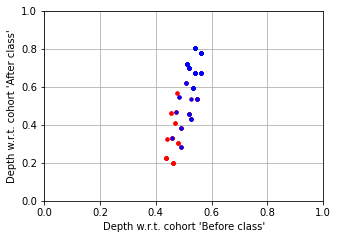

In [15]:
print("Plotting DD-plot")
depths1 = np.transpose(np.array([qrdepth(d1, d1), qrdepth(d1, d2)]))
depths2 = np.transpose(np.array([qrdepth(d2, d1), qrdepth(d2, d2)]))
plt.close("all")
plt.figure(1, figsize=(5, 3.5))
#plt.title("DD-plot of difference before and after the class")
plt.title("")
plt.plot(depths1[:,0], depths1[:,1], 'r.')
plt.plot(depths2[:,0], depths2[:,1], 'b.')
plt.xlabel("Depth w.r.t. cohort 'Before class'")
plt.ylabel("Depth w.r.t. cohort 'After class'")
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.grid()
plt.savefig("pic-ddplot-tecnun.pdf")

Plotting the density of the test statistic
[ 3.22685981  4.13014993  1.71625123  3.21148466  2.78290233  4.59332636
 -0.04804735  3.42673677  1.08010436  3.82456881  2.95010709  0.30942491
  4.44726242  2.04489508  0.84178952  1.33187245  4.95272051  1.06472921
  2.28513181  4.18011917  0.66881907  5.06226846  0.3459409   1.39913874
  5.16989452  0.03459409  3.00199823  3.30950125  5.25637974  4.47416894
  3.42097109  2.84632483  2.6964171   5.05458088  4.20702569  4.32041743
  0.02498462  4.58179499  2.91935679  4.7374684   2.13906788  0.85908656
  3.91297592  3.13268701 -2.10639568  3.78420903  5.03344005  2.36777325
  3.75922441  0.69956937  1.77775183  4.76245302  2.06219213  3.36139238
  2.99046687  2.89821596  5.0488152   3.9533357  -0.0307503   3.56703503
  0.94941557  6.0212935   4.54335711  5.96940237  3.50553442  1.23962155
  5.32941171  0.49777051  5.66382124  1.19733988  1.51445237  2.15059924
  3.54205041  5.21601997  1.67012578  2.73677687  3.65544215  3.22493792
  5.4543

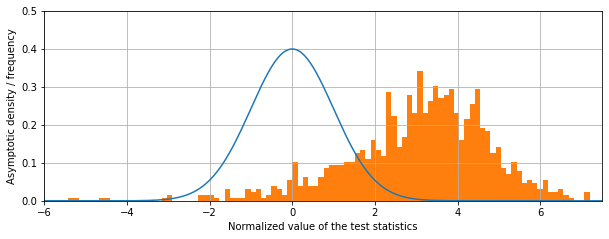

In [17]:
print("Plotting the density of the test statistic")
plt.close("all")
plt.figure(1, figsize=(10, 3.5))
#plt.title("Asymptotic density and evaluations of the test statistic under H0")
plt.title("")
tStatsNorm = (tStats - Wmean) / math.sqrt(Wvar)
print(tStatsNorm)
x = np.linspace(-8.5, 8.5, 1000)
y = norm.pdf(x)
plt.plot(x, y)
#plt.plot(tStatsNorm, np.zeros(len(tStatsNorm)), 'ro')
plt.hist(tStatsNorm, bins = 100, density = True)
plt.xlabel("Normalized value of the test statistics")
plt.ylabel("Asymptotic density / frequency")
plt.ylim(0,0.5)
plt.xlim(-6, 7.5)
plt.grid()
plt.savefig("pic-tstat-tecnun.pdf")